In [2]:
import os, sys

current_path = '/content/drive/My Drive/Colab Notebooks/Project_Stock/'

os.chdir(current_path)

In [ ]:
# !ls

In [1]:
!pip install pandas==0.25.3

### **ARIMA**

In [3]:
from statsmodels.tsa.arima_model import ARIMA


def arima_test(close, use_rows=None):

  size = int(len(close) * 0.66)
  train, test = close[0:size].values, close[size:len(close)]
  test_shift = test.shift(1).values
  test = test.values
  # break

  history = list(train)
  predictions = list()
  err_ranges = list()
  for t in range(len(test)):
    
      if use_rows is not None:
        history = history[-use_rows:]
        
      model = ARIMA(history, order=(0, 2, 1))
      model_fit = model.fit(trend='c', disp=0)
      output = model_fit.forecast()
      # print(output)
      # break
      yhat = output[0]
      predictions.append(yhat)
      err_ranges.append(output[1])
      obs = test[t]
      # print('obs :', obs)
      history.append(obs)
      # break
      print('\r %.2f%%' % (t / len(test) * 100), end='')

  print(len(test), len(predictions))

  return predictions, err_ranges


# print(high)


def get_back_result(ohlcv, predictions, err_ranges, tp=0.04, leverage=1, show_detail=False, show_plot=False, return_pr=False):

  
  high, low, test = np.split(ohlcv.values[-len(predictions):, [1, 2, 3]], 3, axis=1)

  fee = 0.0006
  profits = list()
  win_cnt = 0
  for i in range(len(test)):

    long_ep = (predictions[i] - err_ranges[i]) * (1 / (tp + 1))
    short_ep = (predictions[i] + err_ranges[i]) * (1 / (1 - tp))
    # print((low[i]))
    if low[i] < long_ep:
      
      liquidation = low[i] / long_ep - fee
      l_liquidation = 1 + (liquidation - 1) * leverage
      if max(l_liquidation, 0) == 0:
        l_profit = 0
      else:
        profit = test[i] / long_ep - fee
        l_profit = 1 + (profit - 1) * leverage
        l_profit = max(l_profit, 0)
        
        if profit >= 1:
          win_cnt += 1

      profits.append(l_profit)

      if show_detail:
        print(test[i], predictions[i], long_ep)

    elif high[i] > short_ep:

      liquidation = short_ep / high[i]  - fee
      l_liquidation = 1 + (liquidation - 1) * leverage
      if max(l_liquidation, 0) == 0:
        l_profit = 0
      else:
        profit = short_ep / test[i] - fee
        l_profit = 1 + (profit - 1) * leverage
        l_profit = max(l_profit, 0)

        if profit >= 1:
          win_cnt += 1

      profits.append(l_profit)

      if show_detail:
        print(test[i], predictions[i], short_ep)
    
    else:
      profits.append(1.0)

  win_ratio = win_cnt / sum(np.array(profits) != 1.0)
  frequency = sum(np.array(profits) != 1.0) / len(test)
  accum_profit = np.array(profits).cumprod()

  # print(win_ratio)

  if show_plot:
    plt.plot(profits)
    plt.title('Win Ratio : %.2f %% Frequency : %.2f %%' % (win_ratio * 100, frequency * 100), color='white')
    plt.show()

    # print()
    plt.plot(accum_profit)
    plt.title('Accum_profit : %.2f' % accum_profit[-1], color='white')
    plt.show()

  return win_ratio, frequency, accum_profit[-1], profits


# get_back_result(tp=0.04, leverage=1, show_plot=True)


### **Load OHLCV**

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

interval = '1h'
date_path = './candlestick_concated/%s/' % interval
# date_path_old = './candlestick_concated/%s/old/' % interval
file_list = os.listdir(date_path)
# old_file_list = os.listdir(date_path_old)

# print((file_list))
# print(old_file_list)

# file_list = file_list + old_file_list
print((file_list))


['2021-02-11 BTCUSDT.xlsx', '2021-02-11 ETHUSDT.xlsx', '2021-02-11 BCHUSDT.xlsx', '2021-02-11 XRPUSDT.xlsx', '2021-02-11 EOSUSDT.xlsx', '2021-02-11 LTCUSDT.xlsx', '2021-02-11 ETCUSDT.xlsx', '2021-02-11 LINKUSDT.xlsx', '2021-02-11 XLMUSDT.xlsx', '2021-02-11 ADAUSDT.xlsx', '2021-02-11 XMRUSDT.xlsx', '2021-02-11 SXPUSDT.xlsx', '2021-02-11 KAVAUSDT.xlsx', '2021-02-11 BANDUSDT.xlsx', '2021-02-11 DASHUSDT.xlsx', '2021-02-11 ZECUSDT.xlsx', '2021-02-11 XTZUSDT.xlsx', '2021-02-11 BNBUSDT.xlsx', '2021-02-11 ATOMUSDT.xlsx', '2021-02-11 ONTUSDT.xlsx', '2021-02-11 IOTAUSDT.xlsx', '2021-02-11 BATUSDT.xlsx', '2021-02-11 NEOUSDT.xlsx', '2021-02-11 QTUMUSDT.xlsx', '2021-02-11 WAVESUSDT.xlsx', '2021-02-11 MKRUSDT.xlsx', '2021-02-11 SNXUSDT.xlsx', '2021-02-11 DOTUSDT.xlsx', '2021-02-11 THETAUSDT.xlsx', '2021-02-11 ALGOUSDT.xlsx', '2021-02-11 KNCUSDT.xlsx', '2021-02-11 ZRXUSDT.xlsx', '2021-02-11 COMPUSDT.xlsx', '2021-02-11 OMGUSDT.xlsx', 'old', '2021-02-24 ALGOUSDT.xlsx']


### **Back-Test Analyze**

#### **concate ohlcv**

In [ ]:
import pickle 

# with open('./arima_result/arima_candi_profit_result_%s.pickle' % interval, 'rb') as f:
with open('./arima_result/arima_profit_result_%s.pickle' % interval, 'rb') as f:
  load_candi_pr_dict = pickle.load(f)

# result_dict = dict()

for file in file_list:

  # file = '2021-02-07 ETH.xlsx'
  print(file)
  if not file.endswith('xlsx'):
    continue

  ohlcv = pd.read_excel(date_path + file, index_col=0)
  # print(len(ohlcv))
  temp_dict =  load_candi_pr_dict[file]
  # print(temp_dict['ohlcv'])
  temp_dict['ohlcv'] = ohlcv
  # break

# print(result_dict[file]['ohlcv'])

with open('./arima_result/arima_profit_result_%s.pickle' % interval, 'wb') as f:
# with open('./arima_result/arima_candi_profit_result_%s.pickle' % interval, 'wb') as f:
  pickle.dump(load_candi_pr_dict, f)

#### **Save predictions & err_ranges**

In [ ]:
import pickle

with open('./arima_result/arima_profit_result_%s.pickle' % interval, 'rb') as f:
  load_candi_pr_dict = pickle.load(f)

result_dict = dict()

for file in file_list:

  # file = '2021-02-07 ETH.xlsx'
  print(file)
  if not file.endswith('xlsx'):
    continue

  #     add new data    #
  elif file not in list(load_candi_pr_dict.keys()):

    ohlcv = pd.read_excel(date_path + file, index_col=0)
    print(len(ohlcv))
    # print(ohlcv.head())

    temp_dict =  dict()
    temp_dict['ohlcv'] = ohlcv
    # print(temp_dict)
    load_candi_pr_dict[file] = temp_dict

    # break

    close = ohlcv.iloc[:, [3]]
    predictions, err_ranges = arima_test(close, 3000)

    temp_dict['predictions'] = predictions
    temp_dict['err_ranges'] = err_ranges
    # result_dict[file] = temp_dict
    load_candi_pr_dict[file] = temp_dict

  # break

#         save dict       #
with open('./arima_result/arima_test_result_%s.pickle' % interval, 'wb') as f:
  pickle.dump(load_candi_pr_dict, f)

In [ ]:
while 1: pass

### **Load & Individually Plotting & Add Backtest_Result**

In [ ]:
import pickle
with open('./arima_result/arima_test_result_%s.pickle' % interval, 'rb') as f:
  load_dict = pickle.load(f)

keys = list(load_dict.keys())
# print(keys)
print(list(load_dict[keys[1]].keys()))
print(load_dict[keys[1]]['ohlcv'][-5:])

['ohlcv', 'predictions', 'err_ranges']
[[2530.45  2556.86  2512.89  2515.1   3288.213]
 [2517.27  2593.68  2511.06  2516.15  4280.019]
 [2518.22  2576.55  2516.94  2576.36  3297.623]
 [2576.51  2612.24  2554.43  2580.15  3460.436]
 [2578.46  2592.71  2561.43  2577.15  2760.715]]


In [ ]:
import pickle

with open('./arima_result/arima_test_result_%s.pickle' % interval, 'rb') as f:
  load_dict = pickle.load(f)

tp_list = np.arange(0.001, 0.1, 0.0001)
leverage_list = np.arange(1, 30, 1)
# tp_list = [selected_tp]

for key in load_dict.keys():

  print(key)

  if len(list(load_dict[key].keys())) > 3:
    # print(list(load_dict[key].keys()))
    continue

  #       tp analysis     #
  ohlcv = load_dict[key]['ohlcv']
  predictions = load_dict[key]['predictions']
  err_ranges = load_dict[key]['err_ranges']

  wr_list, fr_list, ap_list = list(), list(), list()
  max_ap_list = list()  

  progress_cnt = 0
  # selected_ap_list = list()
  for tp in tp_list:

    progress_cnt += 1
    print('\r %.2f%%' % (progress_cnt / len(tp_list) * 100), end='')

    #     leverage analysis     #
    temp_ap_list = list()
    for leverage in leverage_list:

      try:
        result = get_back_result(ohlcv, predictions, err_ranges, tp=tp, leverage=leverage)
        temp_ap_list.append(result[2])

        if round(leverage) == 1:

          wr_list.append(result[0])
          fr_list.append(result[1])
          ap_list.append(result[2])

      except Exception as e:
        print(e)
        break

    max_ap_list.append(max(temp_ap_list))

  # print(wr_list)
  # break

  #     stack dict    #
  temp_dict = load_dict[key]
  temp_dict['tp_list'] = tp_list[:len(ap_list)]
  temp_dict['wr_list'] = wr_list
  temp_dict['fr_list'] = fr_list
  temp_dict['ap_list'] = ap_list
  temp_dict['max_ap_list'] = max_ap_list


  #     individual plot   #
  plt.figure(figsize=(15, 5))

  plt.subplot(151)
  plt.plot(tp_list[:len(ap_list)], wr_list)
  plt.title('win ratio')

  plt.subplot(152)
  plt.plot(tp_list[:len(ap_list)], fr_list)
  plt.title('frequency')

  plt.subplot(153)
  plt.plot(tp_list[:len(ap_list)], ap_list)
  argmax = np.argmax(ap_list)
  plt.axvline(tp_list[:len(ap_list)][argmax], linestyle='--')
  plt.title('acc profit, max at %.4f' % (tp_list[:len(ap_list)][argmax]))  

  plt.subplot(154)
  plt.plot(tp_list[:len(max_ap_list)], max_ap_list)
  argmax = np.argmax(max_ap_list)
  plt.axvline(tp_list[:len(max_ap_list)][argmax], linestyle='--')
  plt.title('max acc profit by leverage\n max at %.4f' % (tp_list[:len(max_ap_list)][argmax])) 

  # plt.show()
  selected_tp = tp_list[:len(max_ap_list)][argmax]
  #     leverage analysis     #
  selected_ap_list = list()
  for leverage in leverage_list:

    try:
      result = get_back_result(ohlcv, predictions, err_ranges, tp=selected_tp, leverage=leverage)
      selected_ap_list.append(result[2])

    except Exception as e:
      print(e)
      break
  
  #     stack dict    #
  temp_dict['leverage_list'] = leverage_list[:len(selected_ap_list)]
  temp_dict['leverage_ap_list'] = selected_ap_list
  
  plt.subplot(155)
  plt.plot(leverage_list[:len(selected_ap_list)], selected_ap_list)
  argmax = np.argmax(selected_ap_list)
  plt.title('acc profit by leverage\n max at tp=%.3f lvrg=%.0f' % (selected_tp, leverage_list[:len(selected_ap_list)][argmax]))  
  plt.axvline(leverage_list[:len(selected_ap_list)][argmax], linestyle='--')
  plt.xlim(0, 13)

  plt.show()


#         save dict 2       #
with open('./arima_result/arima_profit_result_%s.pickle' % interval, 'wb') as f:
  pickle.dump(load_dict, f)
  

### **Sum Plot**

In [ ]:
import pickle 

with open('./arima_result/arima_profit_result_%s.pickle' % interval, 'rb') as f:
  profit_result_dict = pickle.load(f)

with open('./arima_result/old/arima_profit_result_%s.pickle' % interval, 'rb') as f:
  old_dict = pickle.load(f)

In [ ]:
# profit_result_dict.update(old_dict)
list(profit_result_dict['2021-02-11 ADAUSDT.xlsx'].keys())

In [ ]:
#         save dict 2       #
with open('./arima_result/arima_profit_result_%s.pickle' % interval, 'wb') as f:
  pickle.dump(profit_result_dict, f)
  

dict_keys(['2021-02-11 THETAUSDT.xlsx', '2021-02-11 MKRUSDT.xlsx', '2021-02-11 QTUMUSDT.xlsx', '2021-02-11 SNXUSDT.xlsx', '2021-02-11 DOTUSDT.xlsx', '2021-02-11 COMPUSDT.xlsx', '2021-02-11 OMGUSDT.xlsx', '2021-02-11 XTZUSDT.xlsx', '2021-02-11 KAVAUSDT.xlsx', '2021-02-11 BANDUSDT.xlsx', '2021-02-11 SXPUSDT.xlsx', '2021-02-11 IOTAUSDT.xlsx', '2021-02-11 ZECUSDT.xlsx', '2021-02-11 NEOUSDT.xlsx', '2021-02-11 DASHUSDT.xlsx', '2021-02-11 BNBUSDT.xlsx', '2021-02-11 ATOMUSDT.xlsx', '2021-02-11 BATUSDT.xlsx', '2021-02-11 WAVESUSDT.xlsx', '2021-02-11 ALGOUSDT.xlsx', '2021-02-11 ONTUSDT.xlsx', '2021-02-11 KNCUSDT.xlsx', '2021-02-11 ZRXUSDT.xlsx', '2021-02-11 BTCUSDT.xlsx', '2021-02-11 ETHUSDT.xlsx', '2021-02-11 BCHUSDT.xlsx', '2021-02-11 XRPUSDT.xlsx', '2021-02-11 EOSUSDT.xlsx', '2021-02-11 LTCUSDT.xlsx', '2021-02-11 ETCUSDT.xlsx', '2021-02-11 LINKUSDT.xlsx', '2021-02-11 XLMUSDT.xlsx', '2021-02-11 ADAUSDT.xlsx', '2021-02-11 XMRUSDT.xlsx', '2021-02-24 ALGOUSDT.xlsx'])


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with differe

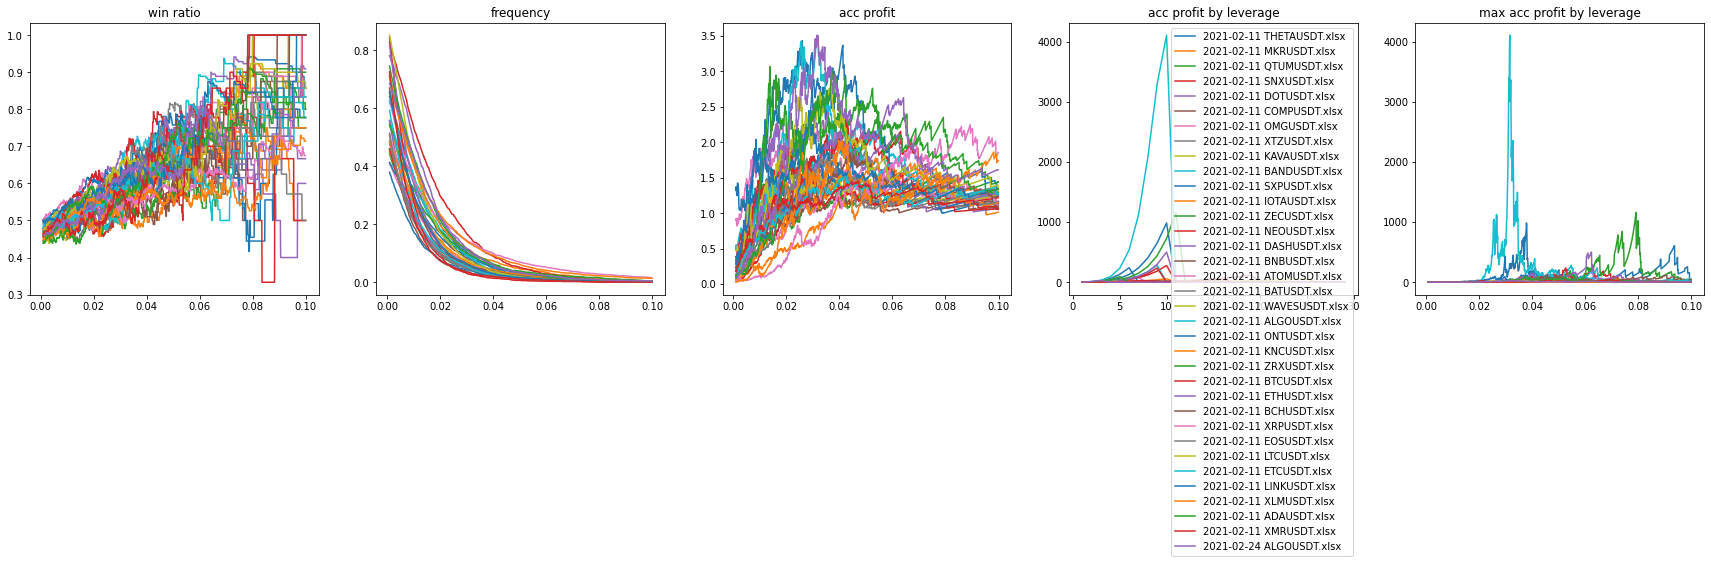

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
# print(type(result_dict))

with open('./arima_result/arima_profit_result_%s.pickle' % interval, 'rb') as f:
  profit_result_dict = pickle.load(f)

keys = profit_result_dict.keys()
print(keys)
# keys = ['2021-02-07 ETH.xlsx']
# break


plt.figure(figsize=(30, 5))

plt.subplot(151)
plt.title('win ratio')  
for key in keys:  
  plt.plot(profit_result_dict[key]['tp_list'], profit_result_dict[key]['wr_list'])


plt.subplot(152)
plt.title('frequency')  
for key in keys:  
  plt.plot(profit_result_dict[key]['tp_list'], profit_result_dict[key]['fr_list'])

  
plt.subplot(153)
plt.title('acc profit')  
for key in keys:  
  plt.plot(profit_result_dict[key]['tp_list'], profit_result_dict[key]['ap_list'])

plt.subplot(155)
plt.title('max acc profit by leverage')  
for key in keys:  
  plt.plot(profit_result_dict[key]['tp_list'], profit_result_dict[key]['max_ap_list'], label=key)
  
plt.subplot(154)
plt.title('acc profit by leverage')  
for key in keys:  
  plt.plot(profit_result_dict[key]['leverage_list'], profit_result_dict[key]['leverage_ap_list'], label=key)
  # print(result_dict[key]['leverage_ap_list'])
plt.legend()

plt.show()


### **Extract Candidate pairs**

In [10]:
pairs = list(profit_result_dict.keys())
result_df = pd.DataFrame(index=pairs)
profit = list()
max_lv_profit = list()
pr_fr_std = list()
max_pr_fr_std = list()
for key in keys:  
  # print(np.max(profit_result_dict[key]['ap_list']))
  profit.append(np.max(profit_result_dict[key]['ap_list']))
  # print(np.max(profit_result_dict[key]['leverage_ap_list']))
  max_lv_profit.append(np.max(profit_result_dict[key]['leverage_ap_list']))

  ohlcv = profit_result_dict[key]['ohlcv']
  predictions = profit_result_dict[key]['predictions']
  err_ranges = profit_result_dict[key]['err_ranges']
  
  argmax = np.argmax(profit_result_dict[key]['ap_list'])
  peak_tp = profit_result_dict[key]['tp_list'][argmax]
  result = get_back_result(ohlcv, predictions, err_ranges, tp=peak_tp, leverage=1)

  profit_list = result[3]
  pr_list_fr = list(map(lambda x : 0 if x == 1.0 else 1, profit_list))
  profited_index = np.argwhere(np.array(pr_list_fr) == 1)
  # print(profited_index)
  term_list = list()
  for i in range(len(profited_index) - 1):
    term_list.append(profited_index[i + 1] - profited_index[i])

  profit_result_dict[key]['pr_list'] = profit_list
  profit_result_dict[key]['pr_fr_std'] = np.std(term_list)
  pr_fr_std.append(np.std(term_list))

  argmax = np.argmax(profit_result_dict[key]['max_ap_list'])
  max_peak_tp = profit_result_dict[key]['tp_list'][argmax]
  result = get_back_result(ohlcv, predictions, err_ranges, tp=max_peak_tp, leverage=1)

  profit_list = result[3]
  pr_list_fr = list(map(lambda x : 0 if x == 1.0 else 1, profit_list))
  profited_index = np.argwhere(np.array(pr_list_fr) == 1)
  # print(profited_index)
  term_list = list()
  for i in range(len(profited_index) - 1):
    term_list.append(profited_index[i + 1] - profited_index[i])

  profit_result_dict[key]['max_pr_list'] = profit_list
  profit_result_dict[key]['max_pr_fr_std'] = np.std(term_list)
  max_pr_fr_std.append(np.std(term_list))


# result_df['index'] = pairs
result_df['profit']= profit
result_df['max_lv_profit']= max_lv_profit
result_df['pr_fr_std'] = pr_fr_std
result_df['max_pr_fr_std'] = max_pr_fr_std
# print(result_df)

#     sort by values    #
print(result_df.sort_values(by='profit', ascending=False))
print(result_df.sort_values(by=['max_lv_profit'], ascending=False))
print(result_df.sort_values(by=['pr_fr_std'], ascending=True))
print(result_df.sort_values(by=['max_pr_fr_std'], ascending=True))

#     extract candidates    #
candis = result_df.sort_values(by=['max_lv_profit'], ascending=False).index
print(candis)



#         save dict 2       #
# with open('./arima_result/arima_candi_profit_result_%s.pickle' % interval, 'wb') as f:
#   pickle.dump(profit_result_dict, f)

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you m

                             profit  max_lv_profit   pr_fr_std  max_pr_fr_std
2021-02-24 ALGOUSDT.xlsx   3.510724      29.142585   20.037823      20.037823
2021-02-11 ALGOUSDT.xlsx   3.487268    4105.596532   24.204557      24.204557
2021-02-11 SXPUSDT.xlsx    3.433563     240.715129   23.049817      32.012464
2021-02-11 ADAUSDT.xlsx    3.066570      93.044720    7.408222      37.145930
2021-02-11 THETAUSDT.xlsx  2.782590     985.235195   18.334417      26.667050
2021-02-11 LTCUSDT.xlsx    2.764541      38.302187   36.515601      36.515601
2021-02-11 ZRXUSDT.xlsx    2.709256    1157.131627   45.336966     115.084815
2021-02-11 DOTUSDT.xlsx    2.483798      56.826600   11.875233      16.859567
2021-02-11 LINKUSDT.xlsx   2.399806      21.401990   29.363396      29.363396
2021-02-11 SNXUSDT.xlsx    2.324170     278.596293   24.358041      50.270118
2021-02-11 BANDUSDT.xlsx   2.285501     283.292736   51.905776      62.183594
2021-02-11 OMGUSDT.xlsx    2.283491      74.077767   62.396140  

### **Optimization**

In [11]:
for i in range(len(candis)):

  keys = [candis[i]]

  plt.figure(figsize=(25, 5))
  plt.suptitle('%s %s' % (interval, keys))

  plt.subplot(181)
  plt.title('win ratio')  
  for key in keys:  
    plt.plot(profit_result_dict[key]['tp_list'], profit_result_dict[key]['wr_list'])


  plt.subplot(182)
  plt.title('frequency')  
  for key in keys:  
    plt.plot(profit_result_dict[key]['tp_list'], profit_result_dict[key]['fr_list'])

    
  plt.subplot(183)
  for key in keys:  
    plt.plot(profit_result_dict[key]['tp_list'], profit_result_dict[key]['ap_list'])
    argmax = np.argmax(profit_result_dict[key]['ap_list'])
    peak_tp = profit_result_dict[key]['tp_list'][argmax]
    plt.axvline(peak_tp, linestyle='--')
    plt.title('acc profit, max at %.4f' % (peak_tp))  

  plt.subplot(184)
  plt.title('max acc profit by leverage')  
  for key in keys:  
    plt.plot(profit_result_dict[key]['tp_list'], profit_result_dict[key]['max_ap_list'], label=key)
    argmax = np.argmax(profit_result_dict[key]['max_ap_list'])
    max_peak_tp = profit_result_dict[key]['tp_list'][argmax]
    plt.axvline(max_peak_tp, linestyle='--')
    plt.title('max acc profit, max at %.4f' % (max_peak_tp))  


  for key in keys:  
    # print(profit_result_dict[key]['leverage_ap_list'])

    for tp in [peak_tp, max_peak_tp]:

      if tp == peak_tp:
        plt.subplot(185)
      else:
        plt.subplot(186)

      #     leverage analysis     #
      ohlcv = profit_result_dict[key]['ohlcv']
      predictions = profit_result_dict[key]['predictions']
      err_ranges = profit_result_dict[key]['err_ranges']
      leverage_list = profit_result_dict[key]['leverage_list']
      temp_ap_list = list()
      profit_list = list()

      for leverage in leverage_list:

        try:
          result = get_back_result(ohlcv, predictions, err_ranges, tp=tp, leverage=leverage)
          temp_ap_list.append(result[2])

          # if round(leverage) == 1:
          #   profit_list = result[3]

        except Exception as e:
          print(e)
          break

      
      # profit_result_dict[key]['pr_list'] = profit_list

      plt.plot(profit_result_dict[key]['leverage_list'],temp_ap_list, label=key)
      argmax = np.argmax(temp_ap_list)
      plt.title('acc profit by leverage\n max at tp=%.4f lvrg=%.0f' % (tp, profit_result_dict[key]['leverage_list'][argmax]))  
      plt.axvline(profit_result_dict[key]['leverage_list'][argmax], linestyle='--')
    # plt.xlim(0, 13)

    
  plt.subplot(187)
  for key in keys:  
    pr_list = profit_result_dict[key]['pr_list']
    pr_fr_std = profit_result_dict[key]['pr_fr_std']
    pr_list_fr = list(map(lambda x : 0 if x == 1.0 else 1, pr_list))
    plt.title('std : %s' % pr_fr_std)
    plt.plot(pr_list_fr)

  plt.subplot(188)
  for key in keys:  
    pr_list = profit_result_dict[key]['max_pr_list']
    pr_fr_std = profit_result_dict[key]['max_pr_fr_std']
    pr_list_fr = list(map(lambda x : 0 if x == 1.0 else 1, pr_list))
    plt.title('std : %s' % pr_fr_std)
    plt.plot(pr_list_fr)


  
  

  plt.show()

  

Output hidden; open in https://colab.research.google.com to view.

### **Optimization tp2**

In [ ]:

def get_back_result_v2(ohlcv, ohlcv2, predictions, err_ranges, tp=0.04, tp2=0.01, sl=None, leverage=1, show_detail=False, show_plot=False, show_time=False):

  
  high, low, test = np.split(ohlcv.values[-len(predictions):, [1, 2, 3]], 3, axis=1)
  time_index = ohlcv.index[-len(predictions):]

  for back_i in range(len(ohlcv2)):
    if datetime.timestamp(time_index[0]) > datetime.timestamp(ohlcv2.index[-back_i]):
      break
      
  open2, high2, low2, close2 = np.split(ohlcv2.values[back_i:, [0, 1, 2, 3]], 4, axis=1)
  time_index2 = ohlcv2.index[back_i:]
  # print(len(time_index2), len(high2))
  # print(time_index[:5])
  # print(time_index2[:5])
  # print(time_index[-5:])
  # print(time_index2[-5:])

  fee = 0.0006
  profits = list()
  win_cnt = 0
  j = 0
  for i in range(1, len(test)):

    long_ep = (predictions[i] - err_ranges[i]) * (1 / (tp + 1))
    long_exit = predictions[i] * (1 / (1 - tp2))

    # assert long_ep < long_exit, 'long_exit < long_ep !, %s, %s' % (long_exit, long_ep)
    
    short_ep = (predictions[i] + err_ranges[i]) * (1 / (1 - tp))
    short_exit = predictions[i] * (1 / (tp2 + 1))

    # print('long_ep, long_exit :', long_ep, long_exit)

    if long_ep > long_exit or short_ep < short_exit:
      profits.append(0)
      continue

    # assert short_ep > short_exit, 'short_exit > short_ep !, %s, %s' % (short_exit, short_ep)

    # print((low[i]))
    if low[i] < long_ep:
      
      liquidation = low[i] / long_ep - fee
      l_liquidation = 1 + (liquidation - 1) * leverage
      if max(l_liquidation, 0) == 0:
        l_profit = 0
      else:

        #     진입 체결 시점으로부터 이탈 시점까지에서 체결 확인    #
        #     시작 / 종료 / 체결 인덱스 파악    #     
        start_j = None
        while 1:
                    
          # print(i, j, time_index[i - 1], time_index2[j], time_index[i])

          if datetime.timestamp(time_index[i - 1]) <= datetime.timestamp(time_index2[j]) <= datetime.timestamp(time_index[i]):

            start_j = j
            # print(start_j, time_index[i - 1], time_index2[j], time_index[i])

            while 1:
              
              j += 1
              if datetime.timestamp(time_index[i]) <= datetime.timestamp(time_index2[j]):
                
                end_j = j
                break
            break
          
          if start_j is not None:
            break

          j += 1

        exit_on = False
        if show_time: print('i, start_j :', i, start_j, time_index[i - 1], time_index2[start_j], time_index[i])

        for k in range(start_j + 1, end_j + 1):
          if low2[k] < long_ep:
          # if low2[k] < long_ep and open2[k] < close2[k]:
            for l in range(k + 1, end_j + 1):
              if high2[l] > long_exit:
                profit = long_exit / long_ep - fee
                exit_on = True
                # print('time_index[i], time_index2[k], time_index2[l] :', time_index[i], time_index2[k], time_index2[l])
                break
            break

        if not exit_on:
          profit = test[i] / long_ep - fee

        l_profit = 1 + (profit - 1) * leverage
        l_profit = max(l_profit, 0)
        
        if profit >= 1:
          win_cnt += 1

      profits.append(l_profit)

      if show_detail:
        print(test[i], predictions[i], long_ep)

    elif high[i] > short_ep:

      liquidation = short_ep / high[i]  - fee
      l_liquidation = 1 + (liquidation - 1) * leverage
      if max(l_liquidation, 0) == 0:
        l_profit = 0
      else:

        #     진입 체결 시점으로부터 이탈 시점까지에서 체결 확인    #
        #     시작 / 종료 / 체결 인덱스 파악    #     
        start_j = None
        while 1:
                    
          # print(i, time_index[i - 1], time_index2[j], time_index[i])
          
          if datetime.timestamp(time_index[i - 1]) <= datetime.timestamp(time_index2[j]) <= datetime.timestamp(time_index[i]):

            start_j = j
            # print(start_j, time_index[i - 1], time_index2[j], time_index[i])

            while 1:
              
              j += 1
              if datetime.timestamp(time_index[i]) <= datetime.timestamp(time_index2[j]):
                
                end_j = j
                break
            break
          
          if start_j is not None:
            break

          j += 1

        exit_on = False
        if show_time: print('i, start_j :', i, start_j, time_index[i - 1], time_index2[start_j], time_index[i])

        for k in range(start_j + 1, end_j + 1):
          if high2[k] > short_ep:
          # if high2[k] > short_ep and open2[k] > close2[k]:
            for l in range(k + 1, end_j + 1):
              if low2[l] < short_exit:
                profit = short_ep / short_exit - fee
                exit_on = True
                break
            break

        if not exit_on:
          profit = short_ep / test[i] - fee

        l_profit = 1 + (profit - 1) * leverage
        l_profit = max(l_profit, 0)

        if profit >= 1:
          win_cnt += 1

      profits.append(l_profit)

      if show_detail:
        print(test[i], predictions[i], short_ep)
    
    else:
      profits.append(1.0)

  win_ratio = win_cnt / sum(np.array(profits) != 1.0)
  frequency = sum(np.array(profits) != 1.0) / len(test)
  accum_profit = np.array(profits).cumprod()

  # print(win_ratio)

  if show_plot:
    plt.plot(profits)
    plt.title('Win Ratio : %.2f %% Frequency : %.2f %%' % (win_ratio * 100, frequency * 100), color='white')
    plt.show()

    # print()
    plt.plot(accum_profit)
    plt.title('Accum_profit : %.2f' % accum_profit[-1], color='white')
    plt.show()

  return win_ratio, frequency, accum_profit[-1], profits


In [ ]:
key = '2021-02-24 ALGOUSDT.xlsx'
tp, leverage = 0.0316, 2
# ohlcv2 = pd.read_excel(date_path.replace(interval, '1m') + key, index_col=0)

tp2_list = np.arange(-0.03, 0.02, 0.0001)


# ohlcv = pd.read_excel(date_path + file, index_col=0)

#       tp analysis     #
ohlcv = profit_result_dict[key]['ohlcv']
predictions = profit_result_dict[key]['predictions']
err_ranges = profit_result_dict[key]['err_ranges']

 0.20%

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:169: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:170: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


 100.00%

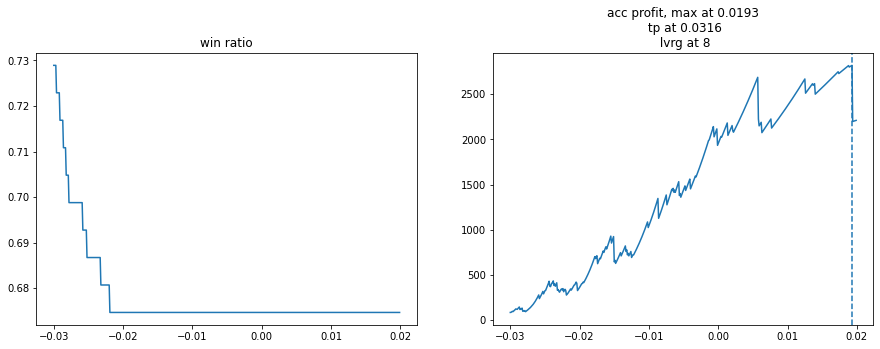

In [ ]:
from datetime import datetime

wr_list, fr_list, ap_list = list(), list(), list()
max_ap_list = list()  

progress_cnt = 0
# selected_ap_list = list()
for tp2 in tp2_list:

  progress_cnt += 1
  print('\r %.2f%%' % (progress_cnt / len(tp2_list) * 100), end='')


  # try:
    # result = get_back_result(ohlcv, predictions, err_ranges, tp=tp2, leverage=leverage, show_plot=False)
  result = get_back_result_v2(ohlcv, ohlcv2, predictions, err_ranges, tp=tp, tp2=tp2, leverage=leverage, show_plot=False)

  wr_list.append(result[0])
  fr_list.append(result[1])
  ap_list.append(result[2])
    
  # except Exception as e:
  #   print(e)
  #   break


# print(wr_list)
# break


#     individual plot   #
plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.plot(tp2_list[:len(ap_list)], wr_list)
plt.title('win ratio')

plt.subplot(122)
plt.plot(tp2_list[:len(ap_list)], ap_list)
argmax = np.argmax(ap_list)
plt.axvline(tp2_list[:len(ap_list)][argmax], linestyle='--')
plt.title('acc profit, max at %.4f\n tp at %.4f\n lvrg at %s' % (tp2_list[:len(ap_list)][argmax], tp, leverage))  
plt.show()



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local

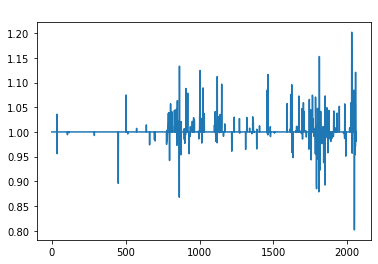

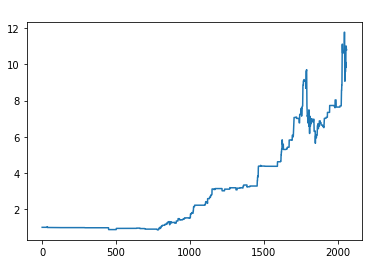

(0.6294642857142857, 0.10868510431829209, array([10.80623737]))


In [ ]:
result = get_back_result(ohlcv, predictions, err_ranges, tp=tp, leverage=leverage, show_plot=True)
print(result[:3])
# result = get_back_result_v2(ohlcv, ohlcv2, predictions, err_ranges, tp=tp, tp2=0.0193, leverage=leverage, show_plot=True)
# result = get_back_result_v2(ohlcv, ohlcv2, predictions, err_ranges, tp=tp, tp2=tp2_list[:len(ap_list)][argmax], leverage=leverage, show_plot=True)
# print(result[:3])

In [ ]:
while True:pass

KeyboardInterrupt: ignored